# a realization using gradient-based decision tree

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt


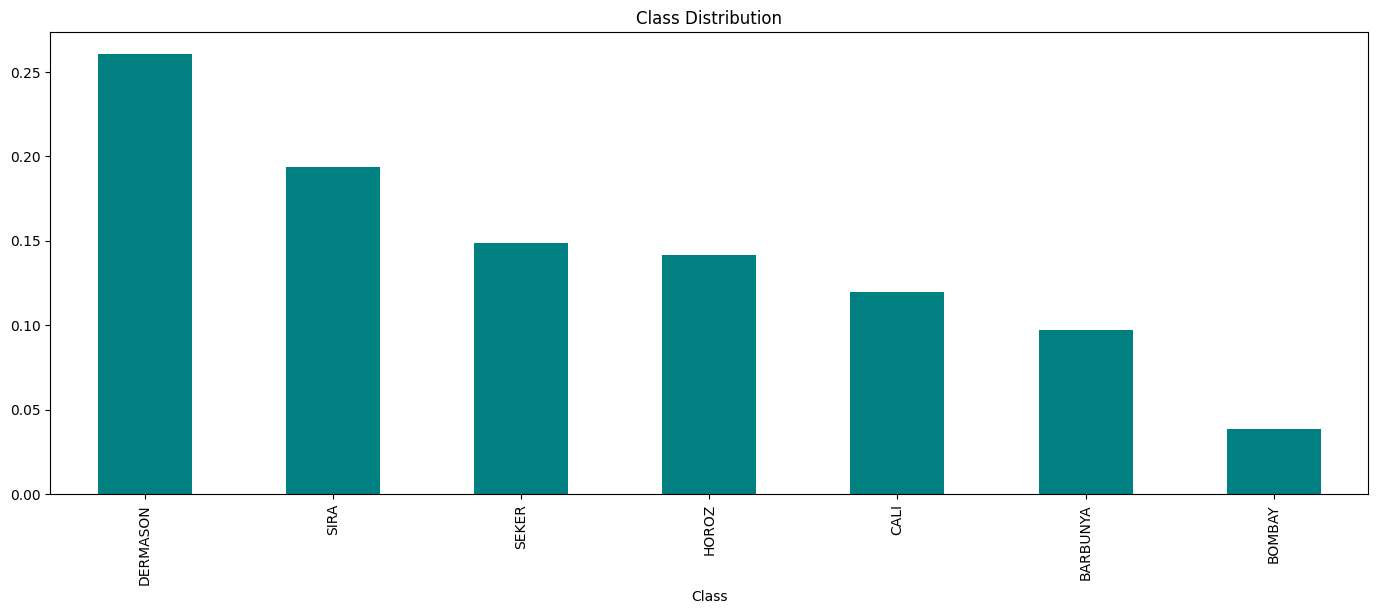

In [ ]:
df = pd.read_excel('Dry_Bean_Dataset.xlsx')
class_dist = df['Class'].value_counts(normalize=True)

plt.figure(figsize=(17,6))
class_dist.plot(kind='bar', color='teal')
plt.title('Class Distribution')
plt.show()

## data standarization

In [ ]:
features = df.columns[:-1]
scaler = RobustScaler()
df[features] = scaler.fit_transform(df[features])

X = df.iloc[:, :-1] 
y = df.iloc[:, -1]   

numeric_features = X.select_dtypes(include=['float64', 'int64']).columns

# calculate their corralation to process the similar data

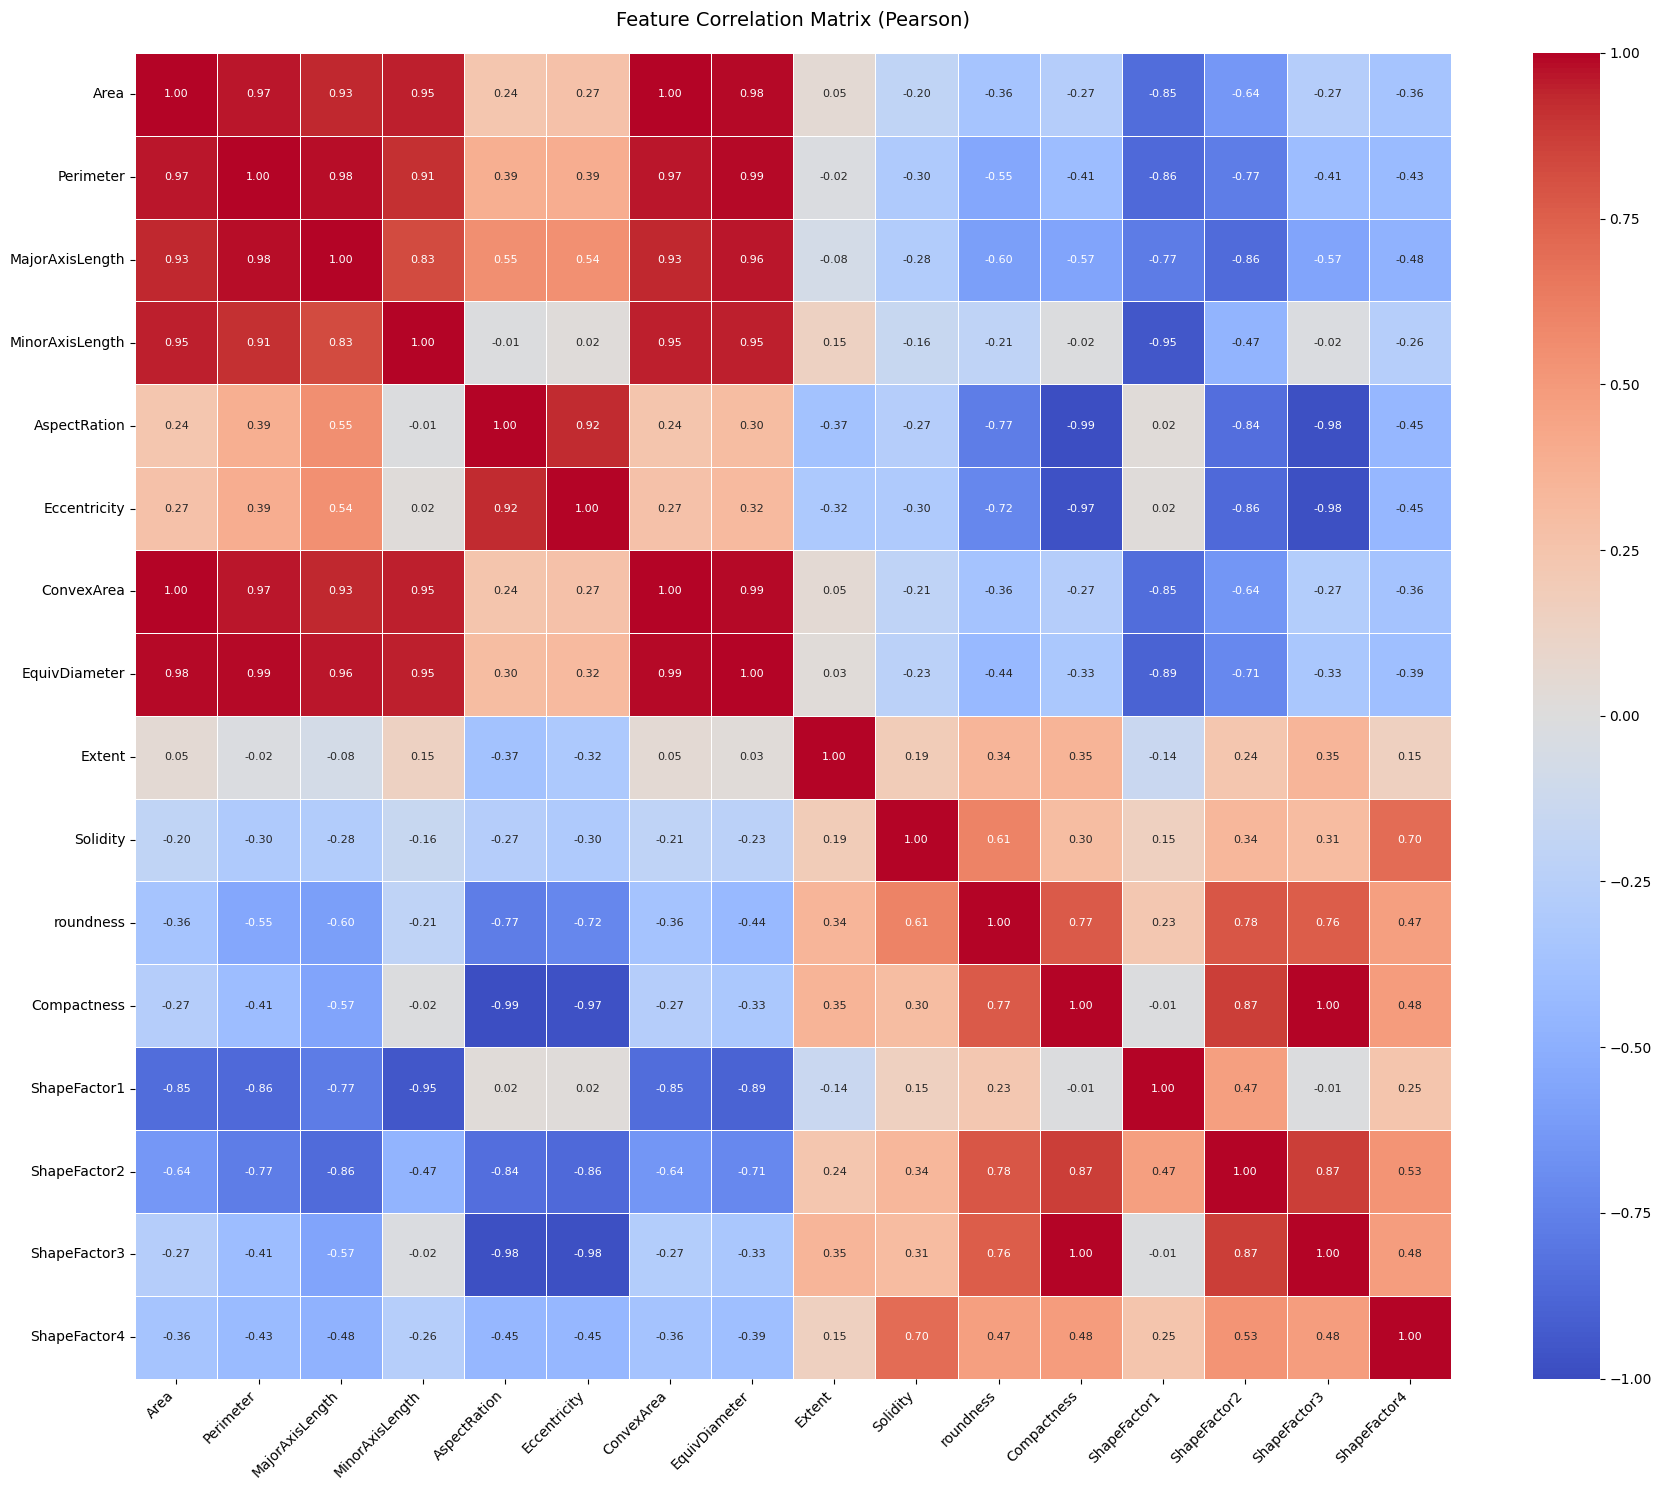

In [ ]:

# 计算相关系数矩阵
corr_matrix = X[numeric_features].corr()

# 绘制热力图（优化版）
plt.figure(figsize=(18, 15))
sns.heatmap(
    corr_matrix,
    annot=True,         # 显示数值
    fmt=".2f",         # 小数格式
    cmap='coolwarm',   # 冷暖色区分正负相关
    vmin=-1, vmax=1,   # 固定色标范围
    linewidths=0.5,    # 单元格间线条
    annot_kws={"size":8} # 注释字体大小
)

plt.title("Feature Correlation Matrix (Pearson)", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:

df = pd.read_excel('Dry_Bean_Dataset.xlsx')
high_corr_pairs = [
    (feature1, feature2)
    for feature1 in corr_matrix.columns
    for feature2 in corr_matrix.columns
    if feature1 != feature2 and abs(corr_matrix[feature1][feature2]) > 0.98
]
print("Highly correlated feature pairs (correlation > 0.98):")
print(high_corr_pairs)

Highly correlated feature pairs (correlation > 0.98):
[('Area', 'ConvexArea'), ('Area', 'EquivDiameter'), ('Perimeter', 'EquivDiameter'), ('AspectRation', 'Compactness'), ('Eccentricity', 'ShapeFactor3'), ('ConvexArea', 'Area'), ('ConvexArea', 'EquivDiameter'), ('EquivDiameter', 'Area'), ('EquivDiameter', 'Perimeter'), ('EquivDiameter', 'ConvexArea'), ('Compactness', 'AspectRation'), ('Compactness', 'ShapeFactor3'), ('ShapeFactor3', 'Eccentricity'), ('ShapeFactor3', 'Compactness')]


In [16]:
df = df.drop(columns=[ 'Eccentricity', 'ConvexArea', 'EquivDiameter',  'Compactness'])
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Extent,Solidity,roundness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.763923,0.988856,0.958027,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.783968,0.984986,0.887034,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.778113,0.989559,0.947849,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.782681,0.976696,0.903936,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.773098,0.990893,0.984877,0.006697,0.003665,0.941900,0.999166,SEKER


In [ ]:
test_set, train_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'])
test_set.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Extent,Solidity,roundness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
12803,36002,700.889,257.888986,178.268649,1.446631,0.797386,0.989936,0.920954,0.007163,0.002099,0.689241,0.997078,DERMASON
3713,183825,1594.423,582.225240,402.762055,1.445581,0.797852,0.993026,0.908672,0.003167,0.000931,0.690451,0.998102,BOMBAY
8974,45595,801.717,301.092828,193.505323,1.555992,0.769926,0.990033,0.891425,0.006604,0.001670,0.640363,0.996401,SIRA
1743,45084,763.811,261.138204,219.977872,1.187111,0.773098,0.992493,0.971092,0.005792,0.002532,0.841767,0.999271,SEKER
2303,61645,952.199,335.139136,235.843970,1.421021,0.795522,0.986336,0.854382,0.005437,0.001638,0.698808,0.993020,BARBUNYA


In [21]:
df["Class"].unique()

array(['SEKER', 'BARBUNYA', 'BOMBAY', 'CALI', 'HOROZ', 'SIRA', 'DERMASON'],
      dtype=object)

In [24]:
cat_mapping = {
    'SEKER' : 1,
    'BOMBAY' : 2,
    'BARBUNYA' : 3,
    'CALI' : 4,
    'DERMASON' : 5,
    'HOROZ' : 6,
    'SIRA' : 7
}


## **lightgbm实现**

In [ ]:

X_train = train_set.iloc[:, :-1]
y_train = train_set.iloc[:, -1]
X_test = test_set.iloc[:, :-1] 
y_test = test_set.iloc[:, -1]  
y_train = y_train.astype('category').cat.codes
y_test = y_test.astype('category').cat.codes

train_data = lgb.Dataset(X_train, y_train)   
test_data = lgb.Dataset(X_test, y_test, reference=train_data)



params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),  # 类别数量
    'metric': 'multi_logloss',  # 多分类对数损失
    'boosting_type': 'gbdt',  # 梯度提升决策树
    'learning_rate': 0.1,
    'num_leaves': 30,
    'max_depth': 2,
    'min_data_in_leaf': 5,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}


model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=200
)


y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # 获取预测的类别

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9196
